In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

In [78]:
df = pd.read_csv('data/food52_scraped_data.csv')

In [79]:
df.head()

,_id,rating,recipe,title,weblink
0,59d7cf29a980892888190548,14,2 tablespoons unsalted butter\n1/4 cup diced y...,Austin Diner-Style Queso,https://food52.com/recipes/73529-austin-diner-...
1,59d7cf30a98089288819054a,29,1 pound shelled raw peanuts\n1 tablespoon plus...,Mamba (Spicy Haitian Peanut Butter),https://food52.com/recipes/73211-mamba-spicy-h...
2,59d7cf39a98089288819054c,2,2 cups (8 1/2 ounces) all-purpose flour\n1/2 c...,Sheet Pan Muffins,https://food52.com/recipes/73548-sheet-pan-muf...
3,59d7cf3fa98089288819054e,92,"1 1/2 cups (300g) Puy lentils, washed\n4 clove...",Anna Jones' Favorite Lentils with Roasted Toma...,https://food52.com/recipes/73511-anna-jones-fa...
4,59d7cf48a980892888190550,3,2 ounces Seedlip Garden 108\n0.75 ounces Lemon...,Seedlip's A Good Dill,https://food52.com/recipes/73252-seedlip-s-a-g...


In [80]:
df.dropna(inplace=True)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9233 entries, 0 to 9714
Data columns (total 5 columns):
_id        9233 non-null object
rating     9233 non-null int64
recipe     9233 non-null object
title      9233 non-null object
weblink    9233 non-null object
dtypes: int64(1), object(4)
memory usage: 432.8+ KB


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from time import time
import seaborn as sns

In [83]:
def topic_extraction(df, col_name):
    """
    Two algorithms for topic extraction -
    NMF and LatentDirichletAllocation(LDA).
    Need to tie in with K-means clustering
    """

    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=200,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(df[col_name])
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=200,
                                    stop_words='english')
    tf = tf_vectorizer.fit_transform(df[col_name])

    nmf = NMF(n_components=10, random_state=1,
            alpha=.1, l1_ratio=.5)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    nmf_w = nmf.fit_transform(tfidf)
    nmf_h = nmf.components_
    df['labels'] = nmf_w.argmax(axis=1) # this was the right code to get labels/clusters
    labels = df['labels'].values

    # tsne_algorithm(tfidf) # feed the tsne algorithm
    # sns.distplot(df['labels'], kde=True)
    # plt.show()
    print("\nTopics in NMF model:")
    print_top_words(nmf, tfidf_feature_names)
#     clustering_algorithm(nmf_w_short, labels)
    """uncomment to LDA topics"""
    lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0,
                                n_jobs=-1)
    mod = lda.fit(tf)
    comp = mod.fit_transform(tf)
    lda_labels = comp.argmax(axis=1)
    df['lda_topics'] = lda_labels
    print("\nTopics in LDA model:")
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names)
    
    return df, labels, lda_labels, tfidf, tf
    

def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print('End')



In [16]:
df, labels, lda_labels, tfidf, tf = topic_extraction(df, 'recipe')


Topics in NMF model:
Topic #0:
chopped diced finely onion chicken tomatoes red minced medium garlic fresh cloves pepper small large celery taste parsley pound beef
Topic #1:
sugar butter flour baking vanilla unsalted purpose teaspoon extract tablespoons egg eggs milk room temperature powder cup granulated soda salt
Topic #2:
grams piece flour coconut pieces pinch yeast oil sugar plus water fine finely grated egg 10 handful olive chocolate seeds
Topic #3:
teaspoon ground powder pepper teaspoons black cumin dried paprika cinnamon salt cayenne coriander seeds chili garlic freshly tablespoon kosher pound
Topic #4:
sauce tablespoon tablespoons soy sesame minced ginger rice vinegar oil garlic sugar chicken teaspoons brown pork lime pounds cloves honey
Topic #5:
olive lemon tablespoons oil fresh pepper extra juice salt virgin freshly black taste tablespoon kosher sea garlic ground leaves zest
Topic #6:
cup cheese grated milk cream sugar heavy shredded coconut parmesan toasted syrup white hon

In [95]:
from mpl_toolkits.mplot3d import Axes3D

In [90]:
def clustering_algorithm(tfidf, labels):

    svd = TruncatedSVD(algorithm='randomized', random_state=42)
    X_new = svd.fit_transform(tfidf)
    tsne_mod = TSNE(n_components=3, verbose=1, random_state=0, perplexity=40)
    coords = tsne_mod.fit_transform(X_new)
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    return x, y, z


In [84]:
rec_stop ="cup cups tablespoon tablespoons teaspoon teaspoons pounds ounces grams gram kilograms kilogram liter liters sliced diced minced finely coarsely roughly cut peeled chopped".split()

In [85]:
rec_stop

['cup',
 'cups',
 'tablespoon',
 'tablespoons',
 'teaspoon',
 'teaspoons',
 'pounds',
 'ounces',
 'grams',
 'gram',
 'kilograms',
 'kilogram',
 'liter',
 'liters',
 'sliced',
 'diced',
 'minced',
 'finely',
 'coarsely',
 'roughly',
 'cut',
 'peeled',
 'chopped']

In [125]:
from sklearn.feature_extraction import text
def topic_extraction(df, col_name):
    """
    Two algorithms for topic extraction -
    NMF and LatentDirichletAllocation(LDA).
    Need to tie in with K-means clustering
    """
    my_stop_words = text.ENGLISH_STOP_WORDS.union(rec_stop)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=200,
                                       analyzer='word',
                                       stop_words=my_stop_words)
    tfidf = tfidf_vectorizer.fit_transform(df[col_name])
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=200,
                                    stop_words=my_stop_words)
    tf = tf_vectorizer.fit_transform(df[col_name])

    nmf = NMF(n_components=6, random_state=1,
            alpha=.1, l1_ratio=.5)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    nmf_w = nmf.fit_transform(tfidf)
    nmf_h = nmf.components_
    labels = nmf_w.argmax(axis=1)
    df['labels2'] = labels # this was the right code to get labels/clusters
#     labels = df['labels'].values

    # tsne_algorithm(tfidf) # feed the tsne algorithm
    # sns.distplot(df['labels'], kde=True)
    # plt.show()
    print("\nTopics in NMF model:")
    print_top_words(nmf, tfidf_feature_names)
#     clustering_algorithm(nmf_w_short, labels)
    """uncomment to LDA topics"""
    lda = LatentDirichletAllocation(n_components=4, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0,
                                n_jobs=-1)
    mod = lda.fit(tf)
    comp = mod.fit_transform(tf)
    lda_labels = comp.argmax(axis=1)
    df['lda_topics2'] = lda_labels
    print("\nTopics in LDA model:")
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names)
    
    return df, labels, lda_labels, tfidf, tf
    

def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print('End')

In [126]:
df4, labels4, lda_labels4, tfidf, tf = topic_extraction(df, 'recipe')


Topics in NMF model:
Topic #0:
oil olive chicken pepper garlic red fresh large salt onion cloves small taste medium leaves white wine tomatoes thyme dried
Topic #1:
flour sugar butter purpose baking vanilla unsalted extract water powder salt egg milk eggs plus soda room temperature cold granulated
Topic #2:
sauce soy sesame rice ginger oil vinegar sugar garlic brown chicken pork chili seeds green water lime vegetable cloves honey
Topic #3:
lemon juice fresh zest lime ounce orange freshly mint honey sugar olive water taste leaves garnish salt oil syrup pinch
Topic #4:
ground black freshly pepper powder pound beef cumin salt kosher cinnamon pork dried paprika coriander cayenne garlic chili cloves onion
Topic #5:
cheese grated cream parmesan slices shredded bread heavy butter milk pound eggs fresh bacon egg pepper sour cooked thinly salt
End

Topics in LDA model:
Topic #0:
sauce oil pepper garlic chicken ground onion salt powder red cloves green ginger rice fresh cumin cilantro soy chili

In [92]:
x5, y5, z5 = clustering_algorithm(tf, labels4)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9233 samples in 0.024s...
[t-SNE] Computed neighbors for 9233 samples in 0.398s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9233
[t-SNE] Computed conditional probabilities for sample 2000 / 9233
[t-SNE] Computed conditional probabilities for sample 3000 / 9233
[t-SNE] Computed conditional probabilities for sample 4000 / 9233
[t-SNE] Computed conditional probabilities for sample 5000 / 9233
[t-SNE] Computed conditional probabilities for sample 6000 / 9233
[t-SNE] Computed conditional probabilities for sample 7000 / 9233
[t-SNE] Computed conditional probabilities for sample 8000 / 9233
[t-SNE] Computed conditional probabilities for sample 9000 / 9233
[t-SNE] Computed conditional probabilities for sample 9233 / 9233
[t-SNE] Mean sigma: 0.064761
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.958397
[t-SNE] Error after 1000 iterations: 0.582283


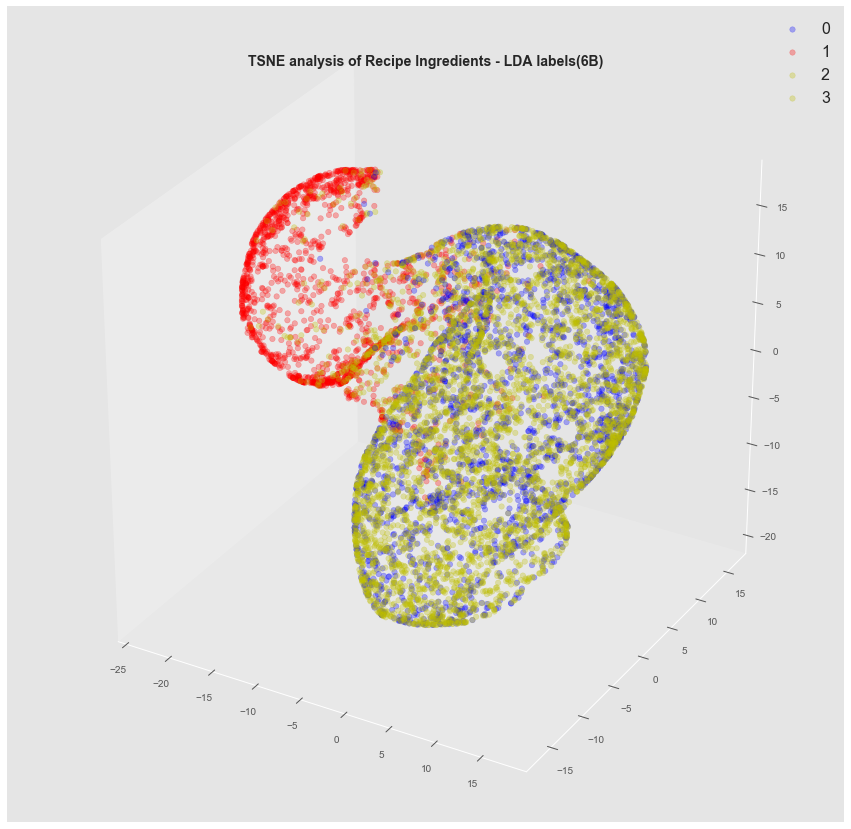

In [128]:
import matplotlib as mpl
""" LDA labels used to identify points in scatter plot of t-SNE analysis of recipe text"""
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
colors = {0:'b', 1:'r', 2:'y', 3:'y'}
for k, b in colors.items():
    x, y, z = x5[np.where(lda_labels4 == k)], y5[np.where(lda_labels4 == k)], z5[np.where(lda_labels4 == k)]    
    ax.scatter(x, y, z, zdir='z', c=colors[k], label=k, s=30, alpha=0.3)
ax.legend(fontsize=16)
# define the colormap
# N = 6
# cmap = plt.cm.jet
# # extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # create the new map
# cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# ax.scatter(x5, y5, z5, zdir='z', c=lda_labels4, s=30, cmap=mpl.colors.ListedColormap(colors), alpha=0.3)
ax.set_title('TSNE analysis of Recipe Ingredients - LDA labels(6B)', fontsize=14, fontweight='bold')
ax.grid(False)

# plt.savefig('data/recipe_ldalabels_tsne.png')

In [120]:
x6, y6, z6 = clustering_algorithm(tfidf, labels4)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9233 samples in 0.018s...
[t-SNE] Computed neighbors for 9233 samples in 0.333s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9233
[t-SNE] Computed conditional probabilities for sample 2000 / 9233
[t-SNE] Computed conditional probabilities for sample 3000 / 9233
[t-SNE] Computed conditional probabilities for sample 4000 / 9233
[t-SNE] Computed conditional probabilities for sample 5000 / 9233
[t-SNE] Computed conditional probabilities for sample 6000 / 9233
[t-SNE] Computed conditional probabilities for sample 7000 / 9233
[t-SNE] Computed conditional probabilities for sample 8000 / 9233
[t-SNE] Computed conditional probabilities for sample 9000 / 9233
[t-SNE] Computed conditional probabilities for sample 9233 / 9233
[t-SNE] Mean sigma: 0.007847
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.588409
[t-SNE] Error after 1000 iterations: 0.595807


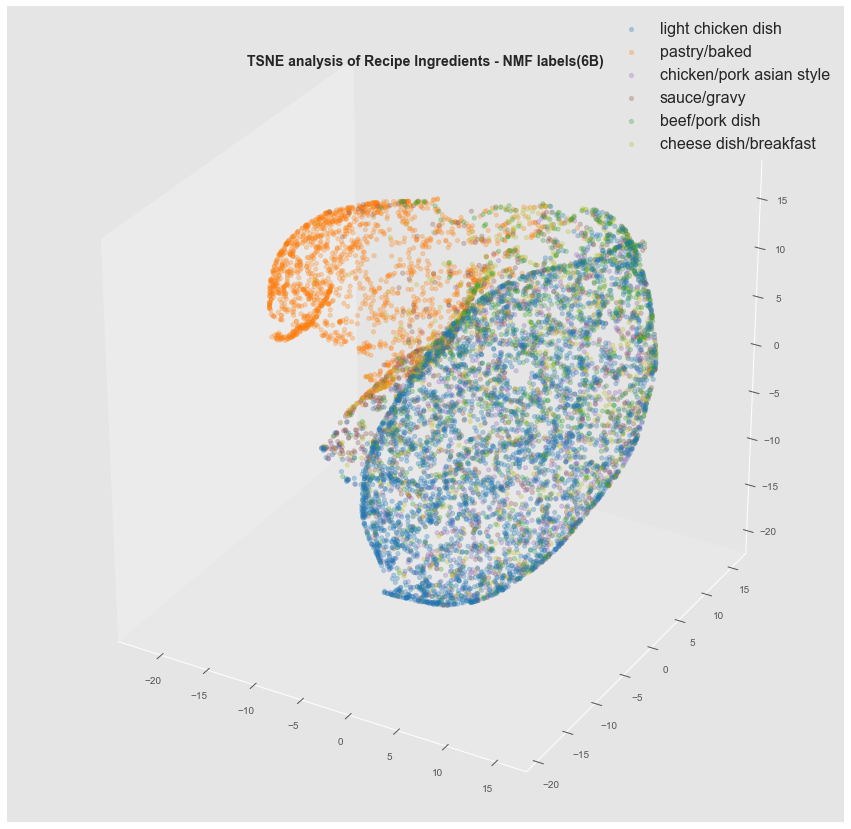

In [130]:
""" NMF labels used to identify points in scatter plot of t-SNE analysis of recipe text"""
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:purple', 3:'tab:brown', 4:'tab:green', 5:'tab:olive'}
labels = {0:'light chicken dish', 1:'pastry/baked', 2:'chicken/pork asian style', 3:'sauce/gravy', 4:'beef/pork dish', 5:'cheese dish/breakfast'}
for k, b in colors.items():
    x, y, z = x6[np.where(labels4 == k)], y6[np.where(labels4 == k)], z6[np.where(labels4 == k)]    
    ax.scatter(x, y, z, zdir='z', c=colors[k], label=labels[k], s=20, alpha=0.3)

ax.legend(fontsize=16)
# define the colormap
# N = 6
# cmap = plt.cm.jet
# # extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # create the new map
# cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# ax.scatter(x5, y5, z5, zdir='z', c=lda_labels4, s=30, cmap=mpl.colors.ListedColormap(colors), alpha=0.)
ax.set_title('TSNE analysis of Recipe Ingredients - NMF labels(6B)', fontsize=14, fontweight='bold')
ax.grid(False)


# {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
# import matplotlib.patches as mpatches
# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x6, y6, z6, zdir='z', c=labels4, cmap='Set1', s=20, alpha=0.4)
# ax.set_title('TSNE analysis of Recipe Ingredients - NMF labels(6B)', fontsize=14, fontweight='bold')
# ax.grid(False)
# plt.savefig('data/recipe_nmfclustering_tsne.png')

In [73]:
from itertools import zip_longest

In [143]:
color_dict = {color: color for color in ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']}

In [86]:
import numpy as np
import holoviews as hv
hv.extension('matplotlib')

:Scatter3D   [x,y,z]
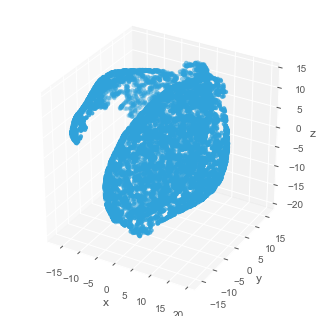

In [90]:
hv.Scatter3D((x6, y6, z6))

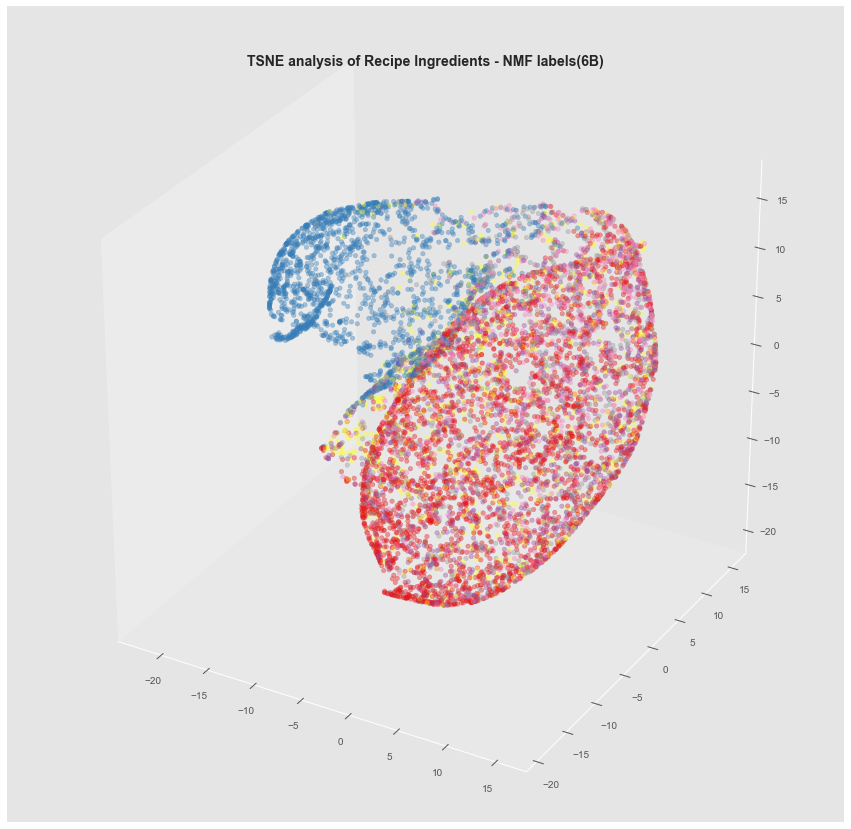

In [372]:
fig = plt.figure(figsize=(15, 15))
hv = fig.add_subplot(111, projection='3d')
hv.scatter(x6, y6, z6, zdir='z', c=labels4, s=20, cmap='Set1', alpha=0.4)
hv.set_title('TSNE analysis of Recipe Ingredients - NMF labels(6B)', fontsize=14, fontweight='bold')
hv.grid(False)
# plt.savefig('data/recipe_nmfclustering_tsne.png')

In [351]:
cmap = plt.cm.get_cmap("Set1", 6)

In [359]:
cmap.

9

In [147]:
df.head()

,_id,rating,recipe,title,weblink,labels,lda_topics,labels2,lda_topics2
0,59d7cf29a980892888190548,14,2 tablespoons unsalted butter\n1/4 cup diced y...,Austin Diner-Style Queso,https://food52.com/recipes/73529-austin-diner-...,0,0,5,1
1,59d7cf30a98089288819054a,29,1 pound shelled raw peanuts\n1 tablespoon plus...,Mamba (Spicy Haitian Peanut Butter),https://food52.com/recipes/73211-mamba-spicy-h...,3,5,4,1
2,59d7cf39a98089288819054c,2,2 cups (8 1/2 ounces) all-purpose flour\n1/2 c...,Sheet Pan Muffins,https://food52.com/recipes/73548-sheet-pan-muf...,1,8,1,5
3,59d7cf3fa98089288819054e,92,"1 1/2 cups (300g) Puy lentils, washed\n4 clove...",Anna Jones' Favorite Lentils with Roasted Toma...,https://food52.com/recipes/73511-anna-jones-fa...,5,0,0,1
4,59d7cf48a980892888190550,3,2 ounces Seedlip Garden 108\n0.75 ounces Lemon...,Seedlip's A Good Dill,https://food52.com/recipes/73252-seedlip-s-a-g...,7,3,3,0


In [18]:
df2 = pd.read_csv('data/food52_addenda_transformed.csv')

In [19]:
df2.reset_index(inplace=True)

In [20]:
del df2['index']
del df2['Unnamed: 0']

In [30]:
df2.head()

,date_submitted,rating,servings,title,user_comments,number_comments,ratio
0,"April 14, 2011",55,4.0,Beef Stroganoff with Mushrooms and Onions,"[""\n\nabout 3 years ago\nCampCook\n\nThere is ...",5,0.090909
1,"October 3, 2016",1,NaN,Asian Sliders with Gochujang Mayo,[],0,0.000000
2,"August 13, 2014",3,NaN,Ground Turkey Stroganoff,['\n\n10 months ago\nHodie-Hi\n\nIngredients l...,2,0.666667
3,"October 4, 2017",64,68.0,Austin Diner-Style Queso,['\n\n23 days ago\nalex\n\nDo as the locals do...,8,0.125000
4,"September 18, 2017",38,1.0,Mamba (Spicy Haitian Peanut Butter),"['\n\n26 days ago\nRegine\n\n“Cooking in HMB,”...",6,0.157895


In [22]:
df2['ratio'] = df2['number_comments'] / df2['rating']

In [23]:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

In [24]:
# df2.dropna(inplace=True)

In [25]:
# df2['ratio'].mean() 

In [27]:
new_df = df.merge(df2, how='left', on='title')

## Analysis of time effect

In [31]:
time_analysis = new_df[['title', 'rating_x', 'rating_y', 'date_submitted']]

In [32]:
time_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9235 entries, 0 to 9234
Data columns (total 4 columns):
title             9235 non-null object
rating_x          9235 non-null int64
rating_y          9235 non-null int64
date_submitted    9235 non-null object
dtypes: int64(2), object(2)
memory usage: 360.7+ KB


In [36]:
# pd.to_datetime(time_analysis['date_submitted'], )
time_analysis.iloc[0, 3]

'October 4, 2017'

In [45]:
from datetime import datetime

In [51]:

def date_change(col):
    return pd.to_datetime(col)

In [43]:
time_analysis['true_date'] = time_analysis['date_submitted'].apply(date_change)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [56]:
date_x = pd.to_datetime('October 30, 2017')

In [57]:
time_analysis['recipe_age'] = date_x - time_analysis['true_date']

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [59]:
time_analysis['delta_rating_45d'] = time_analysis['rating_y'] - time_analysis['rating_x']

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [66]:
time_analysis.rename(columns={'true_date': 'recipe_date'}, inplace=True)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [62]:
del time_analysis['date_submitted']

In [70]:
time_analysis.tail()

,title,rating_x,rating_y,recipe_date,recipe_age,delta_rating_45d,percent_change
9230,Topinambour Soup with Black Trumpets,6,6,2016-11-17,347 days,0,0.000000
9231,Asian Sliders with Gochujang Mayo,0,1,2016-10-03,392 days,1,inf
9232,Asian Sliders with Gochujang Mayo,0,1,2016-10-03,392 days,1,inf
9233,Ground Turkey Stroganoff,3,3,2014-08-13,1174 days,0,0.000000
9234,Ground Turkey Stroganoff,3,3,2014-08-13,1174 days,0,0.000000


In [72]:
time_analysis['percent_change'] = (time_analysis['delta_rating_45d'] / (time_analysis['rating_x'] - 1)) * 100

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [73]:
time_analysis.describe().T

,count,mean,std,min,25%,50%,75%,max
rating_x,9235,168.033,431.279,0,5,37,139,12117
rating_y,9235,168.87,432.275,0,5,38,140,12144
recipe_age,9235,1439 days 17:06:28.651867,849 days 19:03:45.401432,24 days 00:00:00,748 days 00:00:00,1358 days 00:00:00,2216 days 12:00:00,3067 days 00:00:00
delta_rating_45d,9235,0.836925,2.62835,-3,0,0,1,74
percent_change,8674,NaN,NaN,-inf,0,0,0.383142,inf


In [162]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9235 entries, 0 to 9234
Data columns (total 14 columns):
_id                9235 non-null object
rating_x           9235 non-null int64
recipe             9235 non-null object
title              9235 non-null object
weblink            9235 non-null object
labels             9235 non-null int64
lda_topics         9235 non-null int64
labels2            9235 non-null int64
lda_topics2        9235 non-null int64
date_submitted     9235 non-null object
rating_y           9235 non-null int64
user_comments      9235 non-null object
number_comments    9235 non-null int64
date_formatted     9235 non-null object
dtypes: int64(7), object(7)
memory usage: 1.1+ MB


In [197]:
new_df.head()

,_id,rating_x,recipe,title,weblink,labels,lda_topics,labels2,lda_topics2,date_submitted,rating_y,user_comments,number_comments,date_formatted,clean_comments
0,59d7cf29a980892888190548,14,2 tablespoons unsalted butter\n1/4 cup diced y...,Austin Diner-Style Queso,https://food52.com/recipes/73529-austin-diner-...,0,0,5,1,"October 4, 2017",64,['\n\n23 days ago\nalex\n\nDo as the locals do...,8,2011-04-14,[\n\n23 days ago\nalex\n\nDo as the locals do:...
1,59d7cf30a98089288819054a,29,1 pound shelled raw peanuts\n1 tablespoon plus...,Mamba (Spicy Haitian Peanut Butter),https://food52.com/recipes/73211-mamba-spicy-h...,3,5,4,1,"September 18, 2017",38,"['\n\n26 days ago\nRegine\n\n“Cooking in HMB,”...",6,2011-04-14,"[\n\n26 days ago\nRegine\n\n“Cooking in HMB,” ..."
2,59d7cf39a98089288819054c,2,2 cups (8 1/2 ounces) all-purpose flour\n1/2 c...,Sheet Pan Muffins,https://food52.com/recipes/73548-sheet-pan-muf...,1,8,1,5,"October 5, 2017",76,"[""\n\n11 days ago\nGumba\n\nReminds me of HoJo...",14,2011-04-14,[\n\n11 days ago\nGumba\n\nReminds me of HoJo'...
3,59d7cf3fa98089288819054e,92,"1 1/2 cups (300g) Puy lentils, washed\n4 clove...",Anna Jones' Favorite Lentils with Roasted Toma...,https://food52.com/recipes/73511-anna-jones-fa...,5,0,0,1,"October 3, 2017",130,['\n\n18 days ago\nJenn Travis\n\nThese are so...,10,2011-04-14,[\n\n18 days ago\nJenn Travis\n\nThese are so ...
4,59d7cf48a980892888190550,3,2 ounces Seedlip Garden 108\n0.75 ounces Lemon...,Seedlip's A Good Dill,https://food52.com/recipes/73252-seedlip-s-a-g...,7,3,3,0,"September 21, 2017",5,[],0,2011-04-14,[]


In [180]:
test = "".join(new_df.iloc[2, 11])

In [187]:
import ast
test_lst = ast.literal_eval(test)

In [196]:
new_df['clean_comments'] = new_df['user_comments'].apply(lambda x: ast.literal_eval(x))

In [244]:
def clean_com(col):
    return [item.split('\n')[3:]for item in col]
        
        

In [245]:
new_df['clean_comments'] = new_df['clean_comments'].apply(clean_com)

In [296]:
new_df.head()

,_id,rating_x,recipe,title,weblink,labels,lda_topics,labels2,lda_topics2,date_submitted,rating_y,user_comments,number_comments,date_formatted,clean_comments
0,59d7cf29a980892888190548,14,2 tablespoons unsalted butter\n1/4 cup diced y...,Austin Diner-Style Queso,https://food52.com/recipes/73529-austin-diner-...,0,0,5,1,"October 4, 2017",64,['\n\n23 days ago\nalex\n\nDo as the locals do...,8,2011-04-14,"[[alex, , Do as the locals do: On the stovetop..."
1,59d7cf30a98089288819054a,29,1 pound shelled raw peanuts\n1 tablespoon plus...,Mamba (Spicy Haitian Peanut Butter),https://food52.com/recipes/73211-mamba-spicy-h...,3,5,4,1,"September 18, 2017",38,"['\n\n26 days ago\nRegine\n\n“Cooking in HMB,”...",6,2011-04-14,"[[Regine, , “Cooking in HMB,” recipe asks for ..."
2,59d7cf39a98089288819054c,2,2 cups (8 1/2 ounces) all-purpose flour\n1/2 c...,Sheet Pan Muffins,https://food52.com/recipes/73548-sheet-pan-muf...,1,8,1,5,"October 5, 2017",76,"[""\n\n11 days ago\nGumba\n\nReminds me of HoJo...",14,2011-04-14,"[[Gumba, , Reminds me of HoJo's blueberry toas..."
3,59d7cf3fa98089288819054e,92,"1 1/2 cups (300g) Puy lentils, washed\n4 clove...",Anna Jones' Favorite Lentils with Roasted Toma...,https://food52.com/recipes/73511-anna-jones-fa...,5,0,0,1,"October 3, 2017",130,['\n\n18 days ago\nJenn Travis\n\nThese are so...,10,2011-04-14,"[[Jenn Travis, , These are so so yummy. They w..."
4,59d7cf48a980892888190550,3,2 ounces Seedlip Garden 108\n0.75 ounces Lemon...,Seedlip's A Good Dill,https://food52.com/recipes/73252-seedlip-s-a-g...,7,3,3,0,"September 21, 2017",5,[],0,2011-04-14,[]


In [246]:
senti_df = new_df[['title', 'clean_comments', 'number_comments']]

In [247]:
def title_mul(col):
    return list(col)

In [248]:
senti_df['title_mul'] = senti_df['title'].apply(lambda x: [x])

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [249]:
senti_df['title_mul_f'] = senti_df['title_mul'] * senti_df['number_comments']

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [250]:
senti_df.head()

,title,clean_comments,number_comments,title_mul,title_mul_f
0,Austin Diner-Style Queso,"[[alex, , Do as the locals do: On the stovetop...",8,[Austin Diner-Style Queso],"[Austin Diner-Style Queso, Austin Diner-Style ..."
1,Mamba (Spicy Haitian Peanut Butter),"[[Regine, , “Cooking in HMB,” recipe asks for ...",6,[Mamba (Spicy Haitian Peanut Butter)],"[Mamba (Spicy Haitian Peanut Butter), Mamba (S..."
2,Sheet Pan Muffins,"[[Gumba, , Reminds me of HoJo's blueberry toas...",14,[Sheet Pan Muffins],"[Sheet Pan Muffins, Sheet Pan Muffins, Sheet P..."
3,Anna Jones' Favorite Lentils with Roasted Toma...,"[[Jenn Travis, , These are so so yummy. They w...",10,[Anna Jones' Favorite Lentils with Roasted Tom...,[Anna Jones' Favorite Lentils with Roasted Tom...
4,Seedlip's A Good Dill,[],0,[Seedlip's A Good Dill],[]


In [251]:
comments = senti_df['clean_comments']

In [252]:
titles = senti_df['title_mul_f']

In [272]:
combo = []
for n in range(len(comments)):
    comb = list(zip(comments[n], titles[n]))
    combo.extend(comb)

In [274]:
len(combo)

52907

In [275]:
df_working = pd.DataFrame.from_records(combo)

In [276]:
df_working.head()

,0,1
0,"[alex, , Do as the locals do: On the stovetop ...",Austin Diner-Style Queso
1,"[petalpusher, , This recipe is good for those ...",Austin Diner-Style Queso
2,"[EmFraiche, , How much water do you add? I don...",Austin Diner-Style Queso
3,"[Jennifer M, , I put in equal parts milk and w...",Austin Diner-Style Queso
4,"[Ceil_the_great, , Sounds tasty! Can you recom...",Austin Diner-Style Queso


In [277]:
df_working.columns = 'user_comment recipe_title'.split()

In [290]:
df_working.head()

,user_comment,recipe_title,user,comment
0,"[alex, , Do as the locals do: On the stovetop ...",Austin Diner-Style Queso,alex,Do as the locals do: On the stovetop or in the...
1,"[petalpusher, , This recipe is good for those ...",Austin Diner-Style Queso,petalpusher,This recipe is good for those of us who are al...
2,"[EmFraiche, , How much water do you add? I don...",Austin Diner-Style Queso,EmFraiche,How much water do you add? I don’t see an amount.
3,"[Jennifer M, , I put in equal parts milk and w...",Austin Diner-Style Queso,Jennifer M,I put in equal parts milk and water and it see...
4,"[Ceil_the_great, , Sounds tasty! Can you recom...",Austin Diner-Style Queso,Ceil_the_great,Sounds tasty! Can you recommend a substitute f...


In [285]:
def user_id(col):
    if col != []:
        return col[0]
    else:
        return None
df_working['user'] = df_working['user_comment'].apply(user_id)

In [288]:
df_working.iloc[0, 0][-2]

'Do as the locals do: On the stovetop or in the microwave melt 1 block of velveeta cheese and one can of rotel tomatoes.  If you are feeling fancy you can mix in pickled jalapenos, guacamole, ground beef sauteed with onions, or black beans.  Enjoy with college football.'

In [289]:
df_working['comment'] = df_working['user_comment'].apply(lambda x: x[-2])

In [292]:
del df_working['user_comment']

In [294]:
df_working.to_csv('data/recipe_user_comment.csv')

In [295]:
import nltk

In [297]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[autoreload of six failed: Traceback (most recent call last):
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of requests failed: Traceback (most recent call last):
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'RequestsDependencyWarning'
]
[autoreload of requests.models failed: Traceback (most recent call last):
  File "/Applications/anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: __init__() requires a code object with 1 free vars, not 0
]
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/urllib3/contrib/socks.py:37: Depe

In [298]:
slc = SentimentIntensityAnalyzer()

In [303]:
slc.polarity_scores('I am a blah')

{'compound': -0.1027, 'neg': 0.583, 'neu': 0.417, 'pos': 0.0}

In [304]:
def sentence_pos(col):
    return slc.polarity_scores(col)

In [305]:
df_working['pol_scores'] = df_working['comment'].apply(sentence_pos)

In [307]:
df_working['pol_scores'][0]

{'compound': 0.2023, 'neg': 0.056, 'neu': 0.853, 'pos': 0.091}

In [308]:
df_working['compound'] = df_working['pol_scores'].apply(lambda x: x['compound'])

In [310]:
def implicit(col):
    if col <= 0:
        return 0
    if col > 0 and col <= 0.3:
        return 1
    if col > 0.3 and col <= 0.6:
        return 2
    if col > 0.6:
        return 3
df_working['implicit'] = df_working['compound'].apply(implicit)

In [311]:
df_working['implicit'].value_counts()

3    29026
0    13538
2     8228
1     2115
Name: implicit, dtype: int64

In [312]:
df_working['implicit'].mean()

1.9968813200521671

In [314]:
df_working.to_csv('data/implicit_ratings.csv')

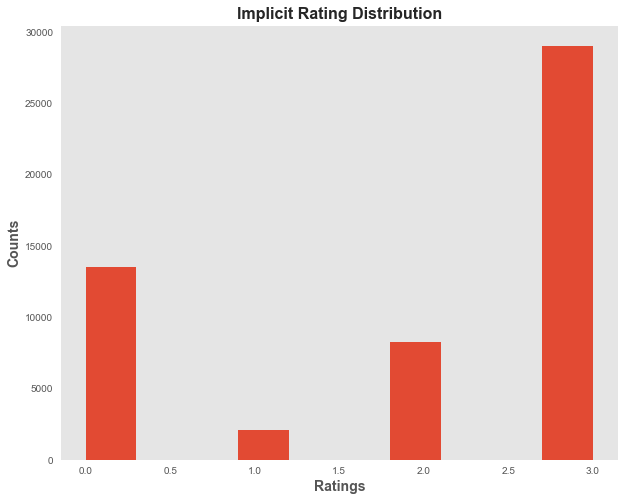

In [371]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(df_working['implicit'])
ax.grid(False)
ax.set_title('Implicit Rating Distribution', fontsize=16, fontweight='bold')
ax.set_ylabel('Counts', fontsize=14, fontweight='bold')
ax.set_xlabel('Ratings', fontsize=14, fontweight='bold')
plt.savefig('data/implicit_dist.png')

In [370]:
df_working['implicit'].value_counts()

3    29026
0    13538
2     8228
1     2115
Name: implicit, dtype: int64

In [369]:
df_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52907 entries, 0 to 52906
Data columns (total 6 columns):
recipe_title    52907 non-null object
user            52907 non-null object
comment         52907 non-null object
pol_scores      52907 non-null object
compound        52907 non-null float64
implicit        52907 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.4+ MB


In [380]:
df_working['user'].value_counts()

AntoniaJames          783
sdebrango             586
aargersi              389
lapadia               379
boulangere            376
hardlikearmour        354
mrslarkin             342
TheWimpyVegetarian    314
drbabs                306
gingerroot            292
Sagegreen             286
dymnyno               272
Midge                 244
fiveandspice          242
EmilyC                237
LE BEC FIN            227
Kristen Miglore       221
healthierkitchen      219
Bevi                  195
sexyLAMBCHOPx         190
Lizthechef            189
wssmom                151
ChefJune              143
QueenSashy            135
lastnightsdinner      134
Regine                127
luvcookbooks          122
inpatskitchen         118
cheese1227            117
monkeymom             114
                     ... 
Alla K                  1
BellaCakes              1
Kelli Heidtmann         1
Sarah Naparalla         1
cini63                  1
Adam Hill               1
Brooke Spillman         1
kpcetal     

In [386]:
df_working.head()

,recipe_title,user,comment,pol_scores,compound,rating
0,Austin Diner-Style Queso,alex,Do as the locals do: On the stovetop or in the...,"{'neg': 0.056, 'neu': 0.853, 'pos': 0.091, 'co...",0.2023,1
1,Austin Diner-Style Queso,petalpusher,This recipe is good for those of us who are al...,"{'neg': 0.137, 'neu': 0.683, 'pos': 0.18, 'com...",0.1779,1
2,Austin Diner-Style Queso,EmFraiche,How much water do you add? I don’t see an amount.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0
3,Austin Diner-Style Queso,Jennifer M,I put in equal parts milk and water and it see...,"{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...",0.2732,1
4,Austin Diner-Style Queso,Ceil_the_great,Sounds tasty! Can you recommend a substitute f...,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.4857,2


In [385]:
df_working.rename(columns={'implicit': 'rating'}, inplace=True)

In [387]:
df_rec = df_working[['user', 'recipe_title', 'rating']]

In [388]:
user_dict = {user: num for num, user in enumerate(list(set(df_rec['user'])))}

In [390]:
recipe_dict = {recipe: num for num, recipe in enumerate(list(set(df_rec['recipe_title'])))}

In [392]:
def recipe_id(col):
    return recipe_dict[col]
def user_id(col):
    return user_dict[col]

In [393]:
df_rec['recipe_id'] = df_rec['recipe_title'].apply(recipe_id)
df_rec['user_id'] = df_rec['user'].apply(user_id)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [394]:
df_rec.head()

,user,recipe_title,rating,recipe_id,user_id
0,alex,Austin Diner-Style Queso,1,647,15949
1,petalpusher,Austin Diner-Style Queso,1,647,17183
2,EmFraiche,Austin Diner-Style Queso,0,647,8403
3,Jennifer M,Austin Diner-Style Queso,1,647,4785
4,Ceil_the_great,Austin Diner-Style Queso,2,647,14093


In [395]:
df_final = df_rec[['user_id', 'recipe_id', 'rating']]

In [397]:
df_final.to_csv('data/f52_user_item_rating.csv')